# Lab 5 - Evaluation II - Model Assessment
---
**Summer 2025 - Intructor: Joyce Yang**

**Adapted from teaching materials by Prof. Chris Volinksy Fall 2024.**

- **Original Notebooks courtesy of Prof. Foster Provost and Rubing Li**

**This notebook not only focused on Evaluation but also lead you through a similar process to your project**

In this notebook, we will walk through everything as a whole, including EDA, data cleaning, model building, model evaluating (Confusion Matrix, Different Curves).

This notebook contains optional task. If you have time, have fun working on optional task. You won't be penalize if you didn't finish optional task.

**Before we begin, remember to save this notebook IN YOUR OWN GOOGLE DRIVE**.  That way you have your own copy to work on, edit and share.

Import all of the packages we will need.

In [32]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



import matplotlib.pylab as plt
%matplotlib inline

## Data Input, EDA, and Data Cleaning

We're going to use a mail response data set from a real direct marketing campaign.  [You can download the data here](https://drive.google.com/uc?export=download&id=1deEx-Ey37F7qznPlIqmaAjjkmkvBtV28).  Each record represents an individual who was targeted with a direct marketing offer.  The offer was a solicitation to make a charitable donation.

The columns (features) are:


|income   |  household income |
|------------|-----------------------|
|Firstdate  |  data assoc. with the first gift by this individual|
|Lastdate   |  data associated with the most recent gift|
|Amount    |   average amount by this individual over all periods (incl. zeros)|
|rfaf2     |   frequency code|
|rfaa2      |  donation amount code|
|pepstrfl  |   flag indicating a star donator|
|glast    |    amount of last gift|
|gavr     |    amount of average gift|


The target variables is `class` and is equal to one if they gave in this campaign and zero otherwise.

### Data Input

In [4]:
from google.colab import files
uploaded = files.upload()

Saving DirectMarketing.csv to DirectMarketing.csv


In [5]:
df = pd.read_csv('DirectMarketing.csv')

### EDA

For EDA, it is our responsibility to get to know your data well. As we discussed in previous lab,we first check about the possible features and feature type. We can also see if there is any miss value with the following function.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191779 entries, 0 to 191778
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Income     191779 non-null  int64  
 1   Firstdate  191779 non-null  int64  
 2   Lastdate   191779 non-null  int64  
 3   Amount     191779 non-null  float64
 4   rfaf2      191779 non-null  int64  
 5   rfaa2      191779 non-null  object 
 6   pepstrfl   191779 non-null  object 
 7   glast      191779 non-null  int64  
 8   gavr       191779 non-null  float64
 9   class      191779 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 14.6+ MB


Again, we will also care about data distribution. Therefore, we can run `.describe` to see statistics of numeric variables. Note the describe won't show categorical variables.

In [7]:
df.describe().round(2)

,Income,Firstdate,Lastdate,Amount,rfaf2,glast,gavr,class
count,191779.00,191779.00,191779.00,191779.00,191779.00,191779.00,191779.00,191779.00
mean,3.02,9136.56,9548.17,0.17,1.91,17.39,13.35,0.05
std,2.30,319.23,49.38,0.10,1.07,28.38,10.14,0.22
min,0.00,0.00,9503.00,0.02,1.00,0.00,1.28,0.00
25%,1.00,8811.00,9509.00,0.10,1.00,10.00,8.40,0.00
50%,3.00,9201.00,9512.00,0.15,1.00,15.00,11.66,0.00
75%,5.00,9409.00,9602.00,0.22,3.00,20.00,15.50,0.00
max,7.00,9603.00,9702.00,1.76,4.00,10000.00,1000.00,1.00


It is always good to actually observe some samples for reference.

In [8]:
df.head()

,Income,Firstdate,Lastdate,Amount,rfaf2,rfaa2,pepstrfl,glast,gavr,class
0,3,9409,9509,0.06,1,G,0,50,30.00,0
1,2,9201,9602,0.16,4,G,X,20,20.55,1
2,0,9510,9603,0.20,4,E,0,5,8.75,0
3,6,9409,9603,0.13,2,G,0,25,22.50,0
4,0,9310,9511,0.10,1,G,0,25,12.50,0


Finally, let's see the visualizations on distribution.

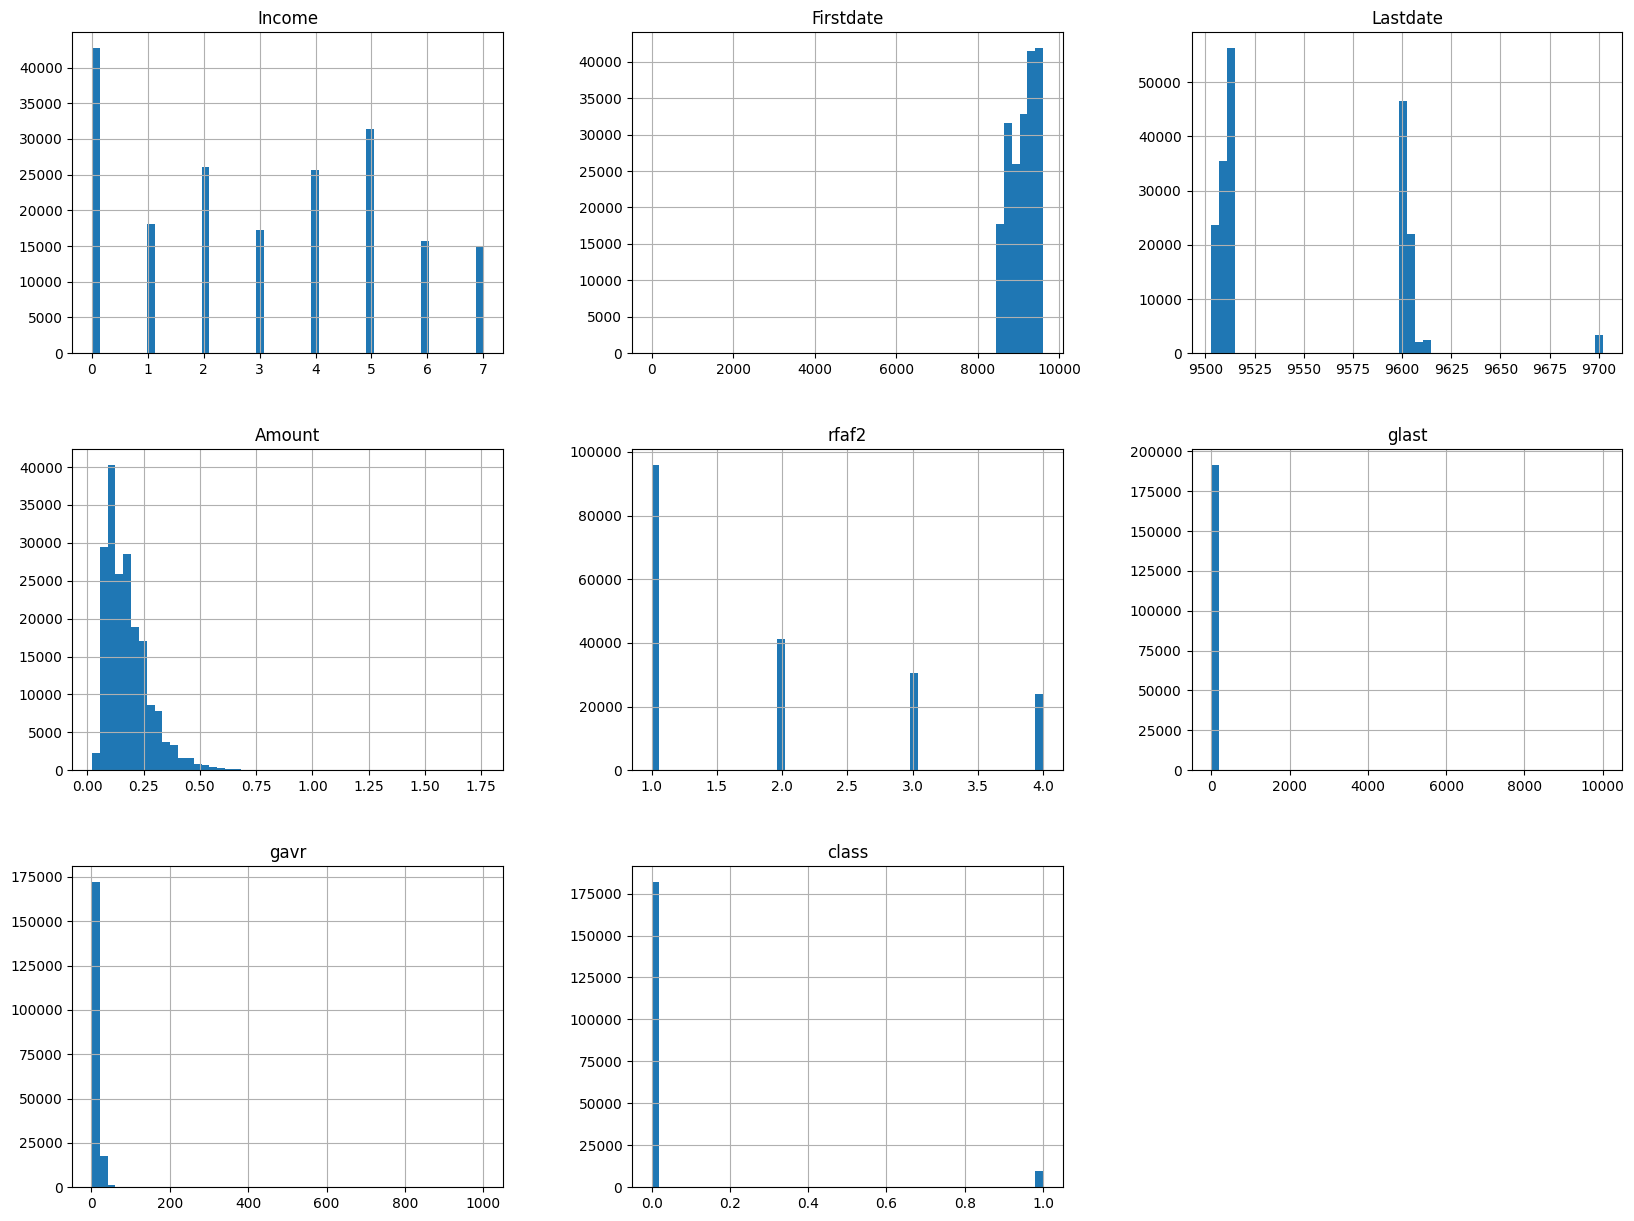

In [9]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

#### Task 1 Data Observation

Based on the previous observation on data, what have you discovered:
1. Is there any missing value?
2. Is there any outliers or invalid value for `Firstdate`? If so what's your decision?
3. Is there any heavily skewed features? How to deal with it?
4. Is our target balanced (50/50)?
5. What variables are categorical features?

No missing values. No outliers in firstdate. First date and amount are skewed. Do log/suare values to reduce skew. Target is not balanced. Flag,dates, and code are categorical

### Data Cleaning

#### Task 2 Data Cleaning
Now let's clean the data.
1. Remove the zeros in `Firstdate`
2. Take a `log` transformation on `gavr` and `glast`
3. Turn all categorical features into dummies. `rfaa2`, `pepstrfl`,`income`,`rfaf2`. Remember to drop one column. For `income` and `rfaf2`, which are shown with numeric type, you can convert the columns in to categorical feature with `pandas.Categorical()`

Name the cleaned data as `df_clean`

Note that the above requirements for data cleaning softly leaking the answer for Task 1. Did you get everything in Task 1 correctly?

In [12]:
df = df[df["Firstdate"] != 0]

# 2. Take a log transformation on 'gavr' and 'glast'
# Add a small value (e.g., 1) to avoid log(0)
df["gavr_log"] = np.log(df["gavr"] + 1)
df["glast_log"] = np.log(df["glast"] + 1)

# 3. Convert 'income' and 'rfaf2' to categorical first
df["Income"] = pd.Categorical(df["Income"])
df["rfaf2"] = pd.Categorical(df["rfaf2"])

# 4. Create dummy variables (drop one level to avoid multicollinearity)
df_dummies = pd.get_dummies(df, columns=["rfaa2", "pepstrfl", "Income", "rfaf2"], drop_first=True)

# 5. Name the final cleaned DataFrame as df_clean
df_clean = df_dummies.copy()
print(df_clean)

        Firstdate  Lastdate  Amount  glast   gavr  class  gavr_log  glast_log  \
0            9409      9509    0.06     50  30.00      0  3.433987   3.931826   
1            9201      9602    0.16     20  20.55      1  3.070376   3.044522   
2            9510      9603    0.20      5   8.75      0  2.277267   1.791759   
3            9409      9603    0.13     25  22.50      0  3.157000   3.258097   
4            9310      9511    0.10     25  12.50      0  2.602690   3.258097   
...           ...       ...     ...    ...    ...    ...       ...        ...   
191774       8706      9507    0.16     20  11.00      0  2.484907   3.044522   
191775       9602      9602    0.07     15  15.00      0  2.772589   2.772589   
191776       8709      9601    0.14     10  10.11      0  2.407846   2.397895   
191777       8704      9512    0.18     15  10.46      0  2.438863   2.772589   
191778       9309      9512    0.08     20  12.50      0  2.602690   3.044522   

        rfaa2_E  rfaa2_F  .

### Feature Engineering

Remember that we discussed about the complexity in dealing with date information. Here, we have `Lastdate` and `Firstdate`. Let's see what we can think of about these two values.

#### Task 3 Date
Maybe we have convert the information into two extra features:
1. `tenure` = Lastdate-Firstdate
2. `recency` = today - Lastdate, where "today" as the max value of Lastdate

Let's create the above two features and append to the `df_clean`. Since we have already used Lastdate and Firstdate, let's remove `Lastdate` and `Firstdate` columns.

In [13]:
# Step 1: Calculate 'tenure' and 'recency'
df_clean["tenure"] = df["Lastdate"] - df["Firstdate"]

# Set "today" as the max of Lastdate
today = df["Lastdate"].max()
df_clean["recency"] = today - df["Lastdate"]

# Step 2: Drop the 'Firstdate' and 'Lastdate' columns
df_clean = df_clean.drop(columns=["Firstdate", "Lastdate"])

## Build the Model

We are going to build a model - specifically Logistic Regression (a type of classification model - NOT a regression model 🤯).   But the model is not useful until we apply *decision logic*, specfically defining the threshold that we will use to determine the action we will take.

### Task 4 Model Building
Remember that to build a model we need to accomplish the following step:
1. Construct `X` and `Y`. (remember to remove useless features)
2. Split our data into training and testing sets
3. Instanize the model `LogisticRegression(C=100000,solver = "liblinear")`. Note that `C` is a regularization parameter, which we talked about or will talk about with regression sessions. `liblinear` is a good general purpose solver (algorithm). If you want to know more about solver, you would need to take an optimization course.
4. Fit the model with training data
5. Get the probability estimation on testing data with `.predict_proba()`

In [25]:
# Step 1: Define X and Y
Y = df_clean["class"]

# Drop target and any other non-predictive/useless columns from X
print(df_clean.columns)
X = df_clean.drop(columns=['rfaa2_E','rfaa2_G','rfaf2_2','rfaf2_3','rfaf2_4'])  # Remove ID or any other identifier

# Step 2: Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# Step 3: Instantiate the model
model = LogisticRegression(C=100000, solver="liblinear")

# Step 4: Fit the model on training data
model.fit(X_train, Y_train)

# Step 5: Predict probabilities on test data
probabilities = model.predict_proba(X_test)

Index(['Amount', 'glast', 'gavr', 'class', 'gavr_log', 'glast_log', 'rfaa2_E',
       'rfaa2_F', 'rfaa2_G', 'pepstrfl_X', 'Income_1', 'Income_2', 'Income_3',
       'Income_4', 'Income_5', 'Income_6', 'Income_7', 'rfaf2_2', 'rfaf2_3',
       'rfaf2_4', 'tenure', 'recency'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evluating the Model with Confusion Matrix

Once we have the `probabilities` prediction, let's understand about the performance better by looking at the prediction distribution.

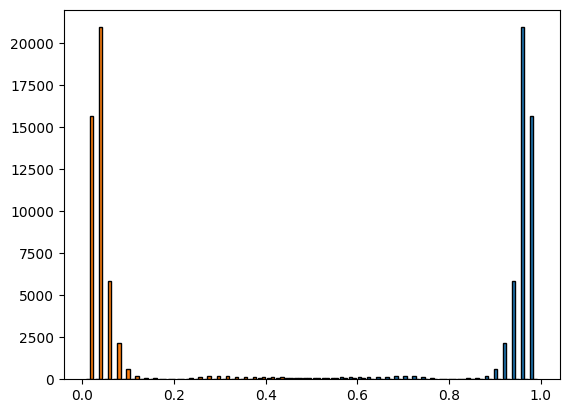

In [26]:
plt.hist(probabilities, bins=50,edgecolor='black') # You can change the probabilities with your own variable
plt.show()

### Task 6 Cutoffs
Remember that we talked about **cutoffs** in the lecture, whereas the default cutoff is 0.5. It is obvious that 0.5 cutoffs doesn't make sense this the above prediction results. Therefore, let's try some other cutoffs.

Let's set the cutoffs as 0.1 . Predictions with probability larger than 0.1 is considered as positive and less than or equal to 0.1 is considered as negative.Please construct the predicted label.

In [28]:
probs_positive = probabilities[:, 1]

# Apply the cutoff to generate predicted labels
pred_labels_cutoff_0_1 = (probs_positive > 0.1).astype(int)

### Task 7 Confusion Matrix

Remember that the confusion matrix is a function of the model (Logistic Regression) but also the decision logic (threshold)  that we set.
Construct the confusion matrix with the threshold of 0.1

Hint:
1. `metrics.confusion_matrix()` is the function to get confusion matrix.
2. Note that the confusion matrix function's output is simply a 2x2 numpy matrix. Remember that in the lecture we also have column and row labels. Therefore, here we convert the 2x2 array into `pandas.Dataframe`.
3. If you read the confusion matrix function documentation carefully, you will noticed that the output of the function has the format of "i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class". It means that the columns are predicted class and rows are labelled class. However, in the lecture we have rows as predicted class and columns as labeled class. Therefore, to align the differences, you can transpose (`.T`) the confusion matrix output. It is not necessary to do so as long as you correctly label the column and row.
4. Correctly label the column and row by setting the dataframe's `column` name and `index`. The final confusion matrix should be named as `conf_mat`

In [30]:
cm = metrics.confusion_matrix(Y_test, pred_labels_cutoff_0_1)

# Convert to DataFrame with labeled axes
conf_mat = pd.DataFrame(
    cm.T,  # transpose to match lecture format (rows = predicted, cols = true)
    index=["Predicted 0", "Predicted 1"],
    columns=["True 0", "True 1"]
)

# Display the confusion matrix
print(conf_mat)

             True 0  True 1
Predicted 0   45169       0
Predicted 1     400    2375


### Task 8 Numeric Metric Computation
Calculate the metrics that we have learned:
- accuracy
- precision
- recall
- F1

Hint: `sklearn.metrics` has functions `precision_score`, `recall_score`, `accuracy_score` and `f1_score`

In [34]:
# Accuracy
accuracy = accuracy_score(Y_test, pred_labels_cutoff_0_1)

# Precision
precision = precision_score(Y_test, pred_labels_cutoff_0_1)

# Recall
recall = recall_score(Y_test, pred_labels_cutoff_0_1)

# F1 Score
f1 = f1_score(Y_test, pred_labels_cutoff_0_1)

# Print the results
print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1 Score :", f1)

Accuracy : 0.9916569330886034
Precision: 0.8558558558558559
Recall   : 1.0
F1 Score : 0.9223300970873787


## ROC Curves and AUC for comparing models

Remember that the Area under the ROC curve (AUC) is a single value to compare models across all thresholds

Using several classification models, we will plot  *ROC curves* and overlay them to see which has the best performance.


### Task 9 Compute ROC Curve and AUC Value

The below coding block is trying to draw the ROC Curve for three differen models (Logistic Regression, Decision Tree and Naive Bayes). Each of the model performance is shown in different colors.
Please finish the missing coding block indicated by `#ToDo:`.

Who is the winner?  

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(C=10000, solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(criterion="entropy", min_samples_leaf=500, random_state=42),
    'Naive Bayes': GaussianNB(),
}

colors = {
    'Logistic Regression': 'blue',
    'Decision Tree': 'orange',
    'Naive Bayes': 'red',
}

In [ ]:
# Dictionary to hold ROC data
roc_data = {}

for name, model in models.items():
  '''ToDo: Please write your code in the following
  Hint:
  1. Fit each model with the training data
  2. Predict the probability for testing data with the fitted model
  3. use roc_curve() function to get the false positive rate and true positive rates and the thresholds.
    Name the variables as fpr, tpr, _ (_ means that we are going to ignore this value and we won't use it later)
  4. use roc_auc_score() function to get the area under the curve. Name the variable as roc_auc
  5. add (fpr, tpr, roc_auc) in roc_data with the name of the model as the key
  '''

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.3f})',color=colors[name])

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Various Models')
plt.legend(loc="lower right")
plt.show()


## Cumulative response and lift curves

ROC is a useful curve to compare models in many situations.  But sometimes this interpretation can be confusing to stakeholders.  

 In some applications the **cumulative response curve** and its associated **lift curve** can be more useful.  Specifically in cases - like targeted advertising - where you will be taking action on a small percentage of your customer base, the lift curve has an appealing interpretation : "How much better does my model do than random chance"?   The lift curve allows comments like **our best model improves our targeting by 4.5x**

Unfortunately, Python does not have a built in model to calculate these curves, so we will provide some user-built functions ...

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


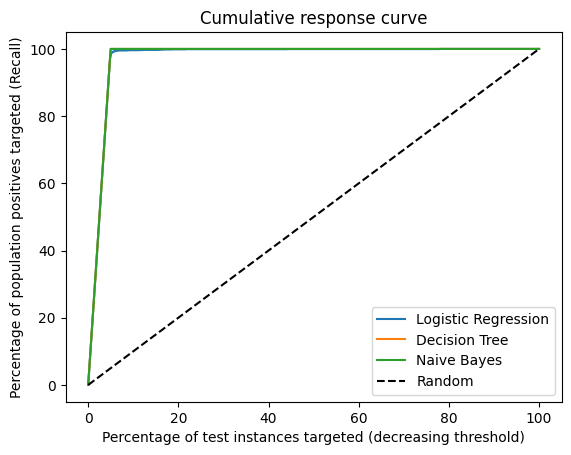

In [36]:
def build_cumulative_curve(model, scale=100):
    # Fit model
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probs = model.predict_proba(X_test)[:, 1]

    # Sort these probabilities and the true value in descending order of probability
    order = np.argsort(Y_test_probs)[::-1]
    Y_test_probs_sorted = Y_test_probs[order]
    Y_test_sorted = np.array(Y_test)[order]

    # Build the cumulative response curve
    x_cumulative = np.arange(len(Y_test_probs_sorted)) + 1
    y_cumulative = np.cumsum(Y_test_sorted)

    # Rescale
    x_cumulative = np.array(x_cumulative)/float(x_cumulative.max()) * scale
    y_cumulative = np.array(y_cumulative)/float(y_cumulative.max()) * scale

    return x_cumulative, y_cumulative

def plot_cumulative_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [0,100], 'k--', label="Random")
    plt.xlabel("Percentage of test instances targeted (decreasing threshold)")
    plt.ylabel("Percentage of population positives targeted (Recall)")
    plt.title("Cumulative response curve")
    plt.legend()

plot_cumulative_curve(models)

We can also plot a **lift curve** in this scenario.  What if we specfically only want to market to the top 1% of our customer base?  Which is best?

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


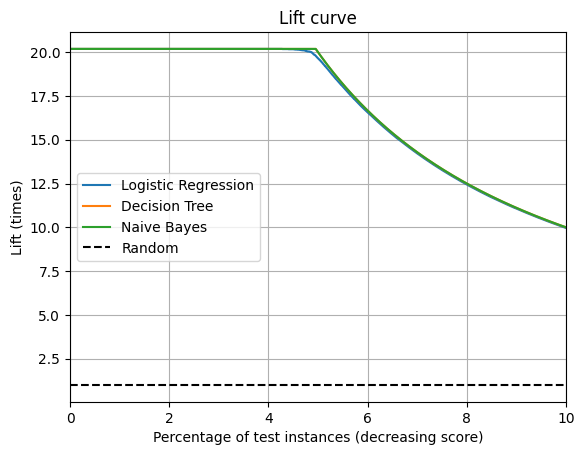

In [37]:
def plot_lift_curve(models):
    # Plot curve for each model
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key])
        plt.plot(x_cumulative, y_cumulative/x_cumulative, label=key)
    # Plot other details
    plt.plot([0,100], [1,1], 'k--', label="Random")
    plt.xlabel("Percentage of test instances (decreasing score)")
    plt.ylabel("Lift (times)")
    plt.title("Lift curve")
    plt.legend()
    plt.grid()
    plt.xlim(0, 10)  # Set x-axis limits to 0-20

plot_lift_curve(models)

## NOTE, might want to focus on left side of plot: plt.xlim(0, 10)

## Profit curves
What if we want to understand not just lift, but how much benefit we are going to receive from a certain investment in targeting?  We can plot a profit curve.

### Task 10 Cost Matrix

Let's say that each offer costs \$1 to make and market, and each accepted offer earns \$18, for a profit of $17. What would the cost matrix be?

Remember we talked about this during the lecture. Now construct the cost matrix as dataframe with columns represents actual and index represents prediction.


In [38]:
conf_matrix = pd.DataFrame(
    data=[[0, -17], [-1, 17]],
    index=["Pred 0", "Pred 1"],
    columns=["Actual 0", "Actual 1"]
)
print(conf_matrix)

        Actual 0  Actual 1
Pred 0         0       -17
Pred 1        -1        17


Remember that we examined different targeting thresholds (aka "decision thresholds"):

In [41]:
print ("Confusion matrix with threshold =",0.1,"to send marketing:\n")
print (conf_mat)
print ("\n")

Confusion matrix with threshold = 0.1 to send marketing:

             True 0  True 1
Predicted 0   45169       0
Predicted 1     400    2375




### Task 11 Compute Profit

The profit can be computed by multiplying confusion matrix by the cost matrix in element wise and then sum all the values.

Hint:
1. `np.multiply` can compute two matrix element wise
2. `np.sum` can be used to sum all elements

In [43]:
conf_mat = np.array([[50, 10],   # predicted = 0: 50 TN, 10 FN
                     [5,  35]])  # predicted = 1: 5 FP, 35 TP

# Cost matrix (same shape)
cost_matrix = np.array([[0, 17],     # predicted = 0: cost 0 for TN, 17 for FN
                        [1, -17]])   # predicted = 1: cost 1 for FP, -17 for TP

# Element-wise multiplication
profit_matrix = np.multiply(conf_mat, cost_matrix)

# Total profit = sum all elements
total_profit = np.sum(profit_matrix)

print("Confusion matrix:\n", conf_mat)
print("\nCost matrix:\n", cost_matrix)
print("\nProfit matrix (conf_mat * cost_matrix):\n", profit_matrix)
print("\nTotal profit: $", total_profit)

Confusion matrix:
 [[50 10]
 [ 5 35]]

Cost matrix:
 [[  0  17]
 [  1 -17]]

Profit matrix (conf_mat * cost_matrix):
 [[   0  170]
 [   5 -595]]

Total profit: $ -420


Now we can plot the profit curve for the two models.

(Note: to calculate the profit curve, you could simply cycle through all of the possible thresholds(using a `for` loop), and store the profit at each threshold, then plot it.

This version is slightly more efficient.

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Max Profit = 39800  with 0.052  % targeted



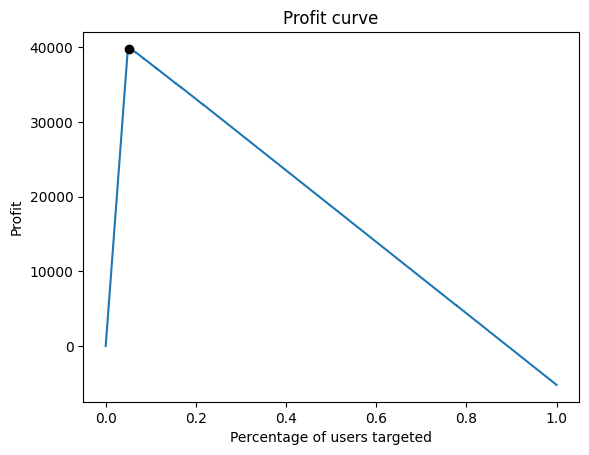

In [44]:
## METHOD 1 - cycle through all of the possible thresholds(using a for loop), and store the profit at each threshold, then plot it.
## note this is just for one model.
model=LogisticRegression(C=10000, solver='liblinear')
model.fit(X_train, Y_train)

## reorder your probabilities (and associated Y_test values) in order of sorted probabilities
probs = model.predict_proba(X_test)[:, 1]
order = np.argsort(probs)[::-1]
probs_sort = probs[order]
Y_test_sort = np.array(Y_test)[order]

## cycle through the probability thresholds from highest to lowest
## at each stage, calculate number marketed to, and the number customers donating
xvec = []
yvec = []
tot_obs = len(Y_test)
tot_pos = Y_test.sum()
max_profit = 0
for prob in probs_sort[:tot_obs]:
  pred_pos = probs_sort >= prob
  Y_test[pred_pos].mean()
  num_donated_customers = Y_test_sort[pred_pos].sum()
  expense = pred_pos.sum()
  revenue = 18 * num_donated_customers
  profit = revenue - expense
  xval = pred_pos.sum()/tot_obs
  yval = profit
  if profit > max_profit:
    max_profit = profit
    max_profit_targeted = xval
  xvec.append(xval)
  yvec.append(yval)
 # print(prob, pred_pos.sum(), num_donated_customers, expense, revenue, profit)

print("Max Profit = %.0f" % max_profit," with %.3f" %max_profit_targeted," % targeted\n")
# format the print statement with 3 decimal place


# plot xvec vs yvec
plt.plot(xvec,yvec)
plt.plot(max_profit_targeted, max_profit, 'ko')
plt.xlabel("Percentage of users targeted")
plt.ylabel("Profit")
plt.title("Profit curve")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max profit is 5194.0 with 100.0 % users targeted
max profit is 5194.0 with 100.0 % users targeted
max profit is 5194.0 with 100.0 % users targeted


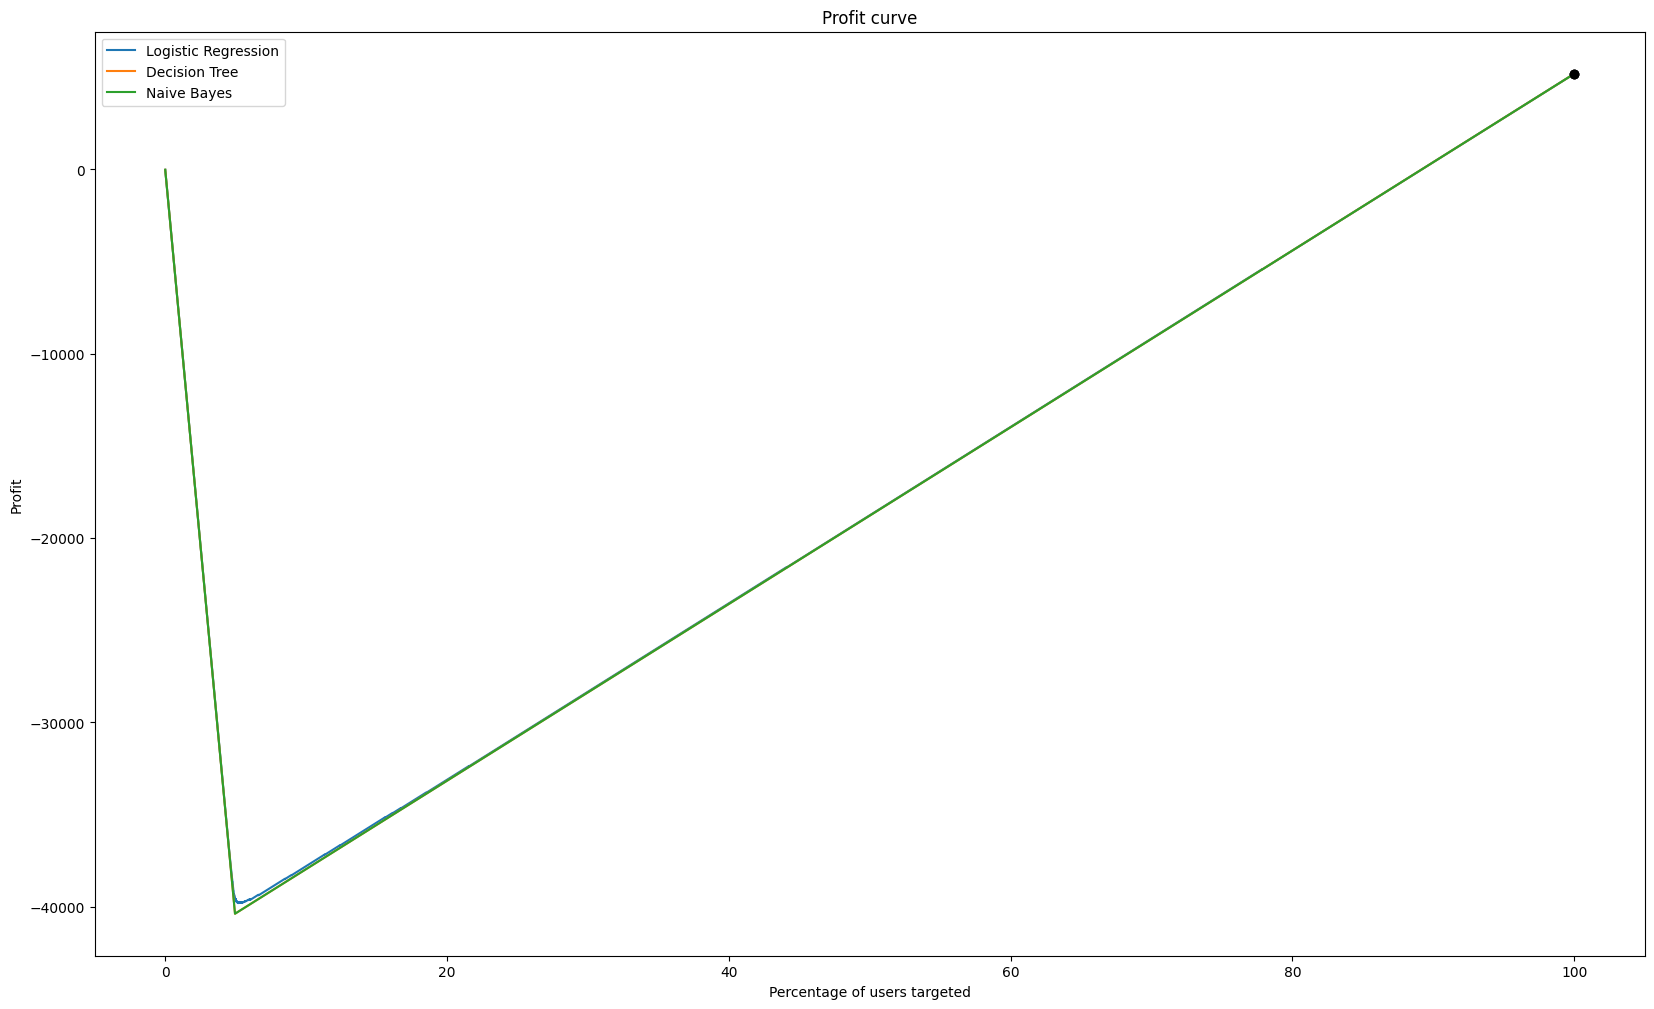

In [53]:
# METHOD 2 - uses our cumulative response curves from above.

cost_df = pd.DataFrame(cost_matrix, index=['Pred0', 'Pred1'], columns=['Actual0', 'Actual1'])

unit_cost = -1 * cost_df.loc['Pred1', 'Actual0']
unit_revenue = cost_df.loc['Pred1', 'Actual1'] + unit_cost
def plot_profit_curve(models):
    # Plot curve for each model
    total_obs = len(Y_test)
    total_pos = Y_test.sum()
    for key in models:
        x_cumulative, y_cumulative = build_cumulative_curve(models[key], scale=1)
        # x_cumulative is cumulative vector of what percentage of population I am targeting
        # y_cumulative is cumulative vector of % of positives among those I am targeting
        pos_profit = unit_revenue * y_cumulative * total_pos
        neg_profit = unit_cost * x_cumulative * total_obs
        profits = pos_profit - neg_profit
        max_profit = profits.max().round(2)
        max_profit_targeted = (100 * x_cumulative[profits.argmax(axis=0)]).round(1)
        plt.plot(x_cumulative * 100, profits, label=key)
        print("max profit is",max_profit,"with",max_profit_targeted,"% users targeted")
        plt.plot(max_profit_targeted, max_profit, 'ko')
    # Plot other details
    plt.xlabel("Percentage of users targeted")
    plt.ylabel("Profit")
    plt.title("Profit curve")
    plt.legend()

plt.figure(figsize=(20,12))
plot_profit_curve(models)

### Task 12 Profit Curve
Given the above plot that shows the profit of three models. Which one would you choose? Why?

In [ ]:
#model 2